In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

In [3]:
mode = 'go_straight'
detection = None
destination = None
prev_mode = None

In [4]:
class_=["center", "left", "right"]

In [5]:
classes = [0, 0, 2, 1]

In [6]:
masks = [
    np.array([[0, 640], [640, 640], [370, 350], [270, 320]]),
    np.array([[0, 640], [640, 640], [400, 350], [300, 350]]),
    np.array([[0, 640], [50, 600], [100, 580], [150, 570], [200, 560],[240, 555], [300, 550], [400, 540], [500, 534], [570, 528], [600, 524], [640, 522], [640, 640]]),
    np.array([[0, 640], [0, 522], [50, 524], [100, 528], [150, 534],[200, 540], [240, 545], [300, 555], [400, 570], [450, 576], [500, 585], [570, 600], [580, 605], [600, 610], [640, 640]])
]

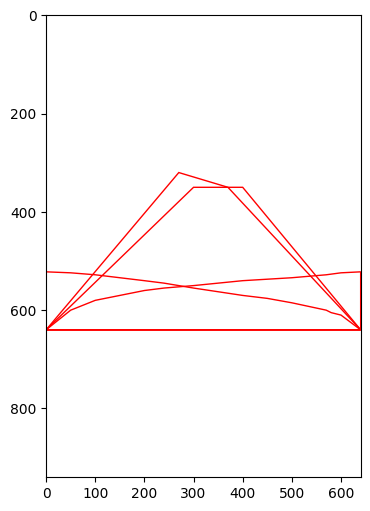

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))

for mask in masks:
    polygon = Polygon(mask, closed=True, edgecolor='r', facecolor='none', linewidth=1)
    ax.add_patch(polygon)

ax.set_xlim(0, 640)
ax.set_ylim(0, 940)
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.invert_yaxis()
plt.show()

global path planning 결과 + 도로 상황(like 표지판, 장애물)에 따라 제어 명령이 달라진다.

In [8]:
cnt = 0

In [9]:
if masks != None:
    for cls_id, mask in zip(classes, masks):
        cnt += 1
        print(cnt)
        if cnt == 3:
            detection = 'go_right'

        if prev_mode != detection and 2 in classes:
            mode = detection
            
        prev_mode = mode
            

1
2
3
4


In [10]:
print(mode)

go_right


In [11]:
match destination:
    case 'go_right':
        print("success")

In [12]:
print(masks[0].shape)

(4, 2)


Bezier Curve Practice

In [13]:
import numpy as np
import scipy.special

def bernstein_poly(i, n, t):
    """ 번스타인 다항식을 계산 """
    return scipy.special.comb(n, i) * (t**i) * ((1 - t)**(n - i))

def bezier_curve(control_points, num_points=100):
    """ 주어진 제어점들로 베지어 곡선을 생성 """
    n = len(control_points) - 1
    t = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    
    for i in range(n + 1):
        curve += np.outer(bernstein_poly(i, n, t), control_points[i])
    
    return curve


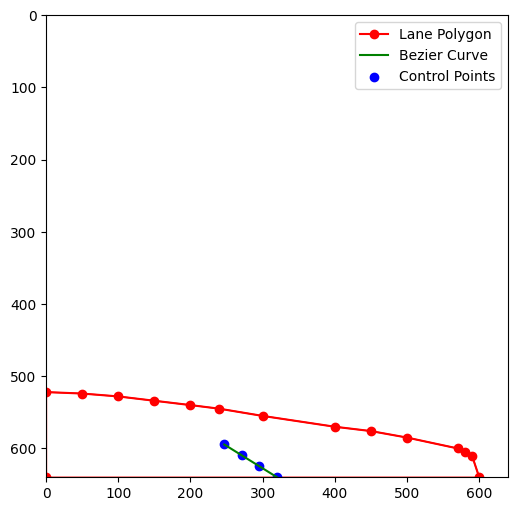

In [14]:
def get_centroid(polygon):
        area = 0
        centroid_x = 0
        centroid_y = 0
        n = len(polygon)

        for i in range(n):
            j = (i + 1) % n
            factor = polygon[i][0] * polygon[j][1] - polygon[j][0] * polygon[i][1]
            area += factor
            centroid_x += (polygon[i][0] + polygon[j][0]) * factor
            centroid_y += (polygon[i][1] + polygon[j][1]) * factor
        area /= 2.0
        if area != 0:
            centroid_x /= (6 * area)
            centroid_y /= (6 * area)
        return (centroid_x, centroid_y)

# 예제: 모델이 예측한 차로의 polygon 좌표
lane_polygon = np.array([[0, 640], [0, 522], [50, 524], [100, 528], [150, 534],[200, 540], [240, 545], [300, 555], [400, 570], [450, 576], [500, 585], [570, 600], [580, 605], [590, 610], [600, 640]])  # 예제 좌표

# 무게중심 계산
centroid = get_centroid(lane_polygon)

# 차량 현재 위치 (예제)
car_position = (320, 640)

# 중간 제어점 추가 (차량 앞쪽 20픽셀 위치)
mid_control1 = (car_position[0]-(car_position[0] - centroid[0]) / 3, 640 - ((car_position[1] - centroid[1]) / 3))
mid_control2 = (car_position[0]-(car_position[0] - centroid[0]) * 2 / 3, 640- ((car_position[1] - centroid[1]) * 2 / 3))


control_points = np.array([car_position, mid_control1, mid_control2, centroid])
bezier_path = bezier_curve(control_points)

fig, ax = plt.subplots(figsize=(6, 6))

polygon = Polygon(lane_polygon, closed=True, edgecolor='r', facecolor='none', linewidth=1)
ax.add_patch(polygon)

ax.set_xlim(0, 640)
ax.set_ylim(0, 640)
ax.set_aspect('equal')
ax.set_facecolor('white')
ax.invert_yaxis()
ax.plot(*zip(*lane_polygon), 'ro-', label="Lane Polygon")  

# 베지어 곡선 경로
ax.plot(bezier_path[:, 0], bezier_path[:, 1], 'g-', label="Bezier Curve")  

# 제어점 표시
ax.scatter(*zip(*control_points), color='blue', label="Control Points")

ax.legend()
plt.show()


In [15]:
test = [[0, 640], [0, 522], [50, 524], [100, 528], [150, 534],[200, 540], [240, 545], [300, 555], [400, 570], [450, 576], [500, 585], [570, 600], [580, 605], [590, 610], [600, 640]]

print(get_centroid(test))

(246.80080482897384, 594.5539906103286)


centroid_x: 373.72725051911567
centroid_y: 593.1659337974838
dest_x: 400
target_y: 540
dist: 53.16593379748383
lookahead_point: [437.32131649 629.86609558]
L_d: 2.186021632788185
steering angle: 13.28976852239573


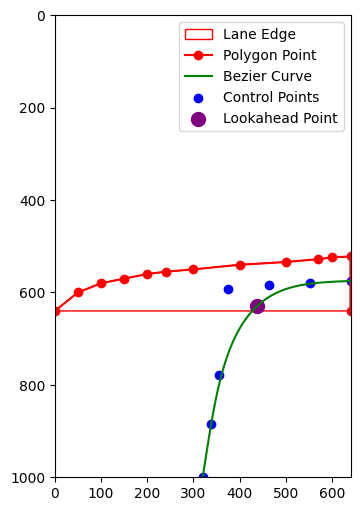

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom

class Conversion:
    def __init__(self, w_res, h_res, inch):
        self.__w_res = w_res
        self.__h_res = h_res
        self.__inch = inch

        self.__PPI = np.sqrt(np.power(self.__w_res, 2)+np.power(self.__h_res, 2))/self.__inch

        self.x = 0
        self.y = 0

    def p2cm(self):
        return  2.54 / self.__PPI
    
def bezier_curve(control_points, num_points=100):
    n = len(control_points) - 1
    t_values = np.linspace(0, 1, num_points)
    curve = np.zeros((num_points, 2))
    
    for i in range(n + 1):
        bernstein_poly = binom(n, i) * (t_values ** i) * ((1 - t_values) ** (n - i))
        curve += np.outer(bernstein_poly, control_points[i])
    
    return curve

def find_lookahead_point(curve, current_pos, lookahead_distance):
    distances = np.linalg.norm(curve - current_pos, axis=1)
    idx = np.argmin(np.abs(distances - lookahead_distance))
    
    # curve[idx][0] -= 320
    # curve[idx][1] = 640 - curve[idx][1]

    return curve[idx]

def find_nearest_value(arr, value):
    # 값과 배열 요소 간 차이의 절댓값을 구하고, 최소 차이를 가지는 인덱스를 찾음
    idx = np.argmin(np.abs(arr - value))
    return arr[idx]

def pure_pursuit_steering(x_pixel, y_pixel, pixel_to_cm, wheelbase_cm):
    """픽셀 좌표를 실제 거리(cm)로 변환 후 조향각 계산"""
    x_pixel -= 320
    y_pixel = 640 - y_pixel

    # 픽셀을 cm로 변환
    x_d = x_pixel * pixel_to_cm
    y_d = y_pixel * pixel_to_cm

    # Lookahead Distance 계산
    L_d = np.hypot(x_d, y_d)
    print(f"L_d: {L_d}")

    # Lookahead 각도 계산
    theta = np.arctan2(y_d, x_d)

    # 조향각 계산
    delta = np.arctan2(2 * wheelbase_cm * np.sin(theta), L_d)

    return np.degrees(delta)

# 차선 edge polygon
# lane_polygon = np.array([[0, 640], [0, 400], [50, 420], [100, 428], [150, 435],
#                          [200, 455], [240, 470], [300, 492], [400, 510], [420, 536],
#                          [430, 555], [470, 580], [480, 605], [490, 610], [500, 640]])
# lane_polygon = np.array([[0, 640], [0, 522], [50, 524], [100, 528], [150, 534],
#                          [200, 540], [240, 545], [300, 555], [400, 570], [450, 576],
#                          [500, 585], [570, 600], [580, 605], [590, 610], [600, 640]])
# lane_polygon = np.array([[0, 640], [0, 580], [50, 585], [100, 589], [150, 592],
#                          [200, 598], [240, 602], [300, 606], [400, 612], [450, 620],
#                          [500, 625], [570, 628], [580, 635], [590, 638], [600, 640]])
lane_polygon = np.array ([[0, 640], [50, 600], [100, 580], [150, 570], [200, 560],[240, 555], [300, 550], [400, 540], [500, 534], [570, 528], [600, 524], [640, 522], [640, 640]])
# lane_polygon = np.array([[0, 640], [640, 640], [400, 350], [300, 350]])
trans_polygon = lane_polygon.copy()

# print(trans_polygon)

# 차량 위치 및 무게중심 (주어진 정보)
car_position = np.array([320, 1000])
centroid = get_centroid(lane_polygon)
print(f"centroid_x: {centroid[0]}")
print(f"centroid_y: {centroid[1]}")

# 평행이동을 하기 위해 무게중심과 가장 근접한 polygon의 x좌표를 추출
dest_x = find_nearest_value(trans_polygon[:,0], centroid[0])
print(f"dest_x: {dest_x}")


target_y = trans_polygon[trans_polygon[:,0]==dest_x][0][1]

print(f"target_y: {target_y}")

dist = centroid[1] - target_y
print(f"dist: {dist}")

if dist > 0:
    trans_polygon[:, 1] += int(dist)
    # print(f"after_transfer: {trans_polygon}")
else:
    trans_polygon[:, 1] -= int(dist)
    # print(f"after_transfer: {trans_polygon}")

sort_index = np.argsort(trans_polygon[:,1])
y_max = trans_polygon[sort_index[0]]

""" car_position ~ centroid"""
mid_control1 = (car_position[0]-(car_position[0] - centroid[0]) / 3, 1000 - ((car_position[1] - centroid[1]) * 13 / 46))
mid_control2 = (car_position[0]-(car_position[0] - centroid[0]) * 2 / 3, 1000- ((car_position[1] - centroid[1]) * 25 / 46))

""" centroid ~ y_max"""
mid_control3 = (centroid[0]-(centroid[0] - y_max[0]) / 3, centroid[1] - ((centroid[1] - y_max[1]) * 5 / 10))
mid_control4 = (centroid[0]-(centroid[0] - y_max[0]) * 2 / 3, centroid[1]- ((centroid[1] - y_max[1])  * 8 / 10))


unit = Conversion(1920, 1080, 16.1)

control_points = np.array([car_position, mid_control1, mid_control2, centroid, mid_control3, mid_control4, y_max])
bezier_path = bezier_curve(control_points)
""" 전방주시거리 [:, 540] ~ [:, 640] = 5cm
    즉, 카메라 화면 하단 100pixel = 5 cm
    전방주시거리를 3cm 정도로 잡기 위해 60pixel로 설정"""
lookahead_distance = 390
lookahead_point = find_lookahead_point(bezier_path, car_position, lookahead_distance)
print(f"lookahead_point: {lookahead_point}")

print(f"steering angle: {pure_pursuit_steering(lookahead_point[0], lookahead_point[1], unit.p2cm(), 3)}")

# 시각화
fig, ax = plt.subplots(figsize=(6, 6))

polygon = Polygon(lane_polygon, closed=True, edgecolor='r', facecolor='none', linewidth=1, label="Lane Edge")
ax.add_patch(polygon)
ax.plot(lane_polygon[:, 0], lane_polygon[:, 1], 'ro-', label="Polygon Point")
ax.plot(bezier_path[:, 0], bezier_path[:, 1], 'g-', label="Bezier Curve")
ax.scatter(*zip(*control_points), color='blue', label="Control Points")
ax.scatter(*lookahead_point, color='purple', s=100, label="Lookahead Point")
# ax.plot(trans_polygon[:, 0], trans_polygon[:, 1], 'bo-', label="transfer Edge")
ax.invert_yaxis()
ax.set_xlim(0, 640)
ax.set_ylim(1000, 0)
ax.set_aspect('equal')
ax.legend()
plt.show()


In [4]:
import numpy as np
def filter_polygon_by_x( polygon, fixed_y=640):
        # unique한 x값들 찾기
        unique_x_values = np.unique(polygon[:, 0])
        
        new_polygon = []
        
        for x in unique_x_values:
            # 특정 x값을 가진 점들만 선택
            x_match_points = polygon[polygon[:, 0] == x]

            # y값 기준으로 정렬
            x_match_points = x_match_points[np.argsort(x_match_points[:, 1])]

            # 가장 위 (최소 y값)과 가장 아래 (최대 y값) 점 찾기
            y_min = x_match_points[0]  # 가장 작은 y값 (고정)
            y_max = x_match_points[-1].copy()  # 가장 큰 y값 (y를 fixed_y로 변경)
            y_max[1] = fixed_y  # y를 640으로 고정

            # 최종 polygon 리스트에 추가
            new_polygon.append(y_min)
            new_polygon.append(y_max)

        return np.array(new_polygon)


In [5]:
# 예제 polygon (x, y 좌표들)
polygon = np.array([
    [500, 100], [500, 200], [500, 300], [500, 700], [500, 800], 
    [400, 50], [400, 600], [400, 700], 
    [600, 500], [600, 650]
])

new_polygon = filter_polygon_by_x(polygon, fixed_y=640)
print(new_polygon)



[[400  50]
 [400 640]
 [500 100]
 [500 640]
 [600 500]
 [600 640]]


NameError: name 'Polygon' is not defined

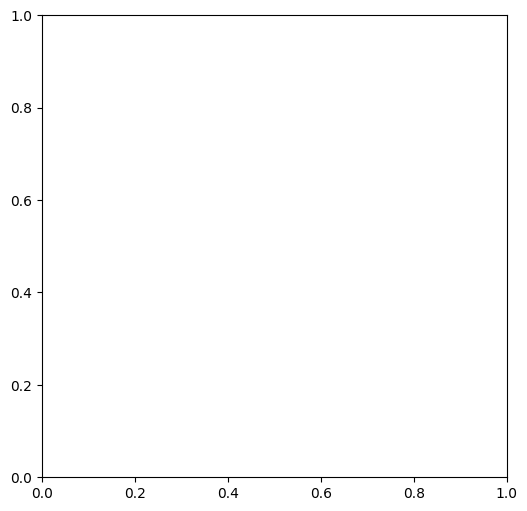

In [1]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))
polygon = Polygon(polygon, closed=True, edgecolor='r', facecolor='none', linewidth=1, label="Lane Edge")
new_polygon = Polygon(new_polygon, closed=True, edgecolor='r', facecolor='none', linewidth=1, label="Lane Edge")


polygon = Polygon(lane_polygon, closed=True, edgecolor='r', facecolor='none', linewidth=1, label="Lane Edge")
ax.add_patch(polygon)
ax.add_patch(new_polygon)
# ax.plot(trans_polygon[:, 0], trans_polygon[:, 1], 'bo-', label="transfer Edge")
ax.invert_yaxis()
ax.set_xlim(0, 640)
ax.set_ylim(1000, 0)
ax.set_aspect('equal')
ax.legend()
plt.show()